**Phu Nguyen, Sean Nightingale**

Imports

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


**Just some cells to help understand our data**

In [14]:
df = pd.read_csv("Dataset/diabetes_prediction_dataset.csv")
print(df.head())
print(df.info())
print(df.describe())


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

In [15]:
# Replace 'No Info' with 'never' for age ≤ 5
df.loc[(df['age'] <= 5) & (df['smoking_history'] == 'No Info'), 'smoking_history'] = 'never'

# Display for confirmation
print(df[df['age'] <= 5])  # to check the changes

       gender   age  hypertension  heart_disease smoking_history    bmi  \
21       Male  5.00             0              0           never  18.80   
24     Female  4.00             0              0           never  13.99   
35       Male  5.00             0              0           never  15.10   
41       Male  5.00             0              0           never  27.32   
49     Female  3.00             0              0           never  19.27   
...       ...   ...           ...            ...             ...    ...   
99911  Female  0.32             0              0           never  18.37   
99916  Female  1.48             0              0           never  27.32   
99933  Female  5.00             0              0           never  13.34   
99940    Male  2.00             0              0           never  16.86   
99996  Female  2.00             0              0           never  17.37   

       HbA1c_level  blood_glucose_level  diabetes  
21             6.2                   85        

**Preprocess Stuff**

In [16]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

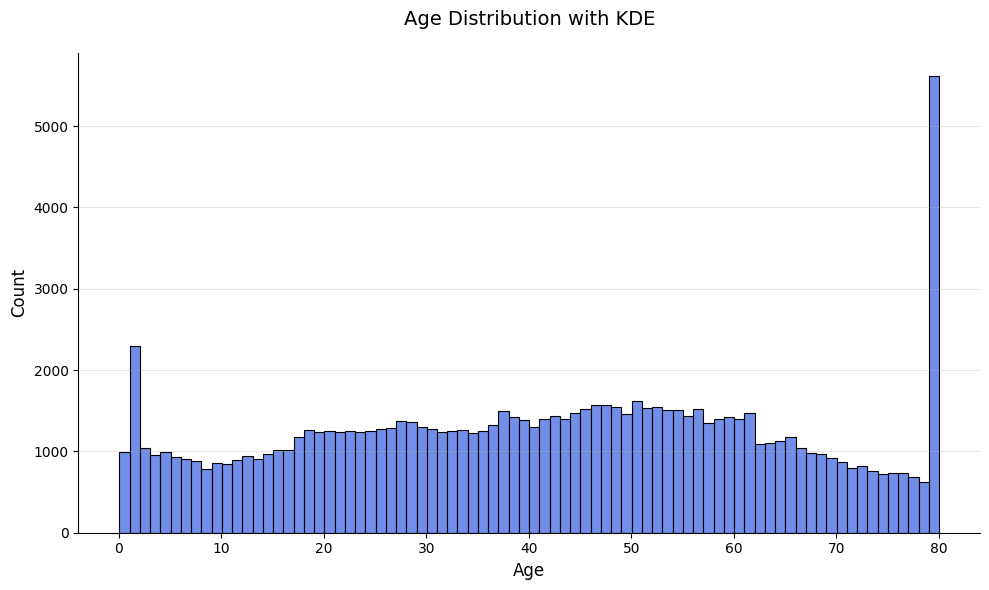

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='age', 
             bins=80,
             color='royalblue',
             edgecolor='black',
             linewidth=0.8)

plt.title('Age Distribution with KDE', 
          fontsize=14, 
          pad=20)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

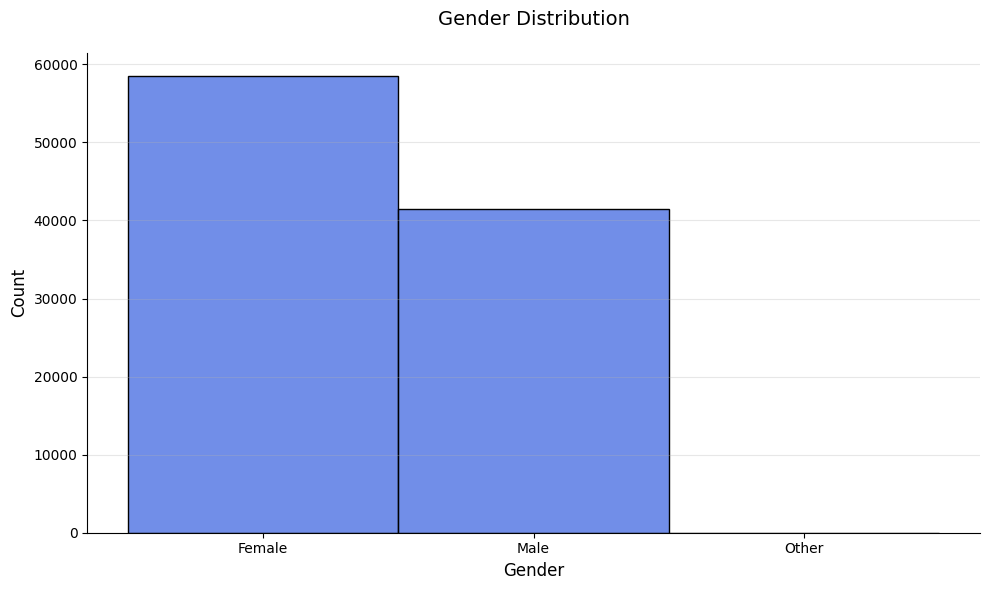

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='gender', 
             bins=3,
             color='royalblue',
             edgecolor='black',
             )

plt.title('Gender Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

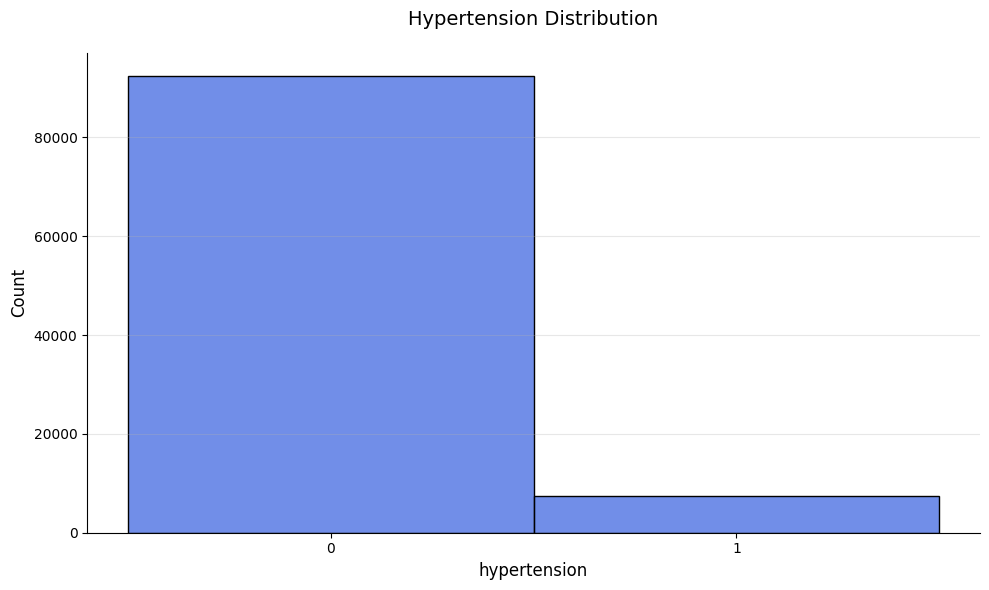

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='hypertension', 
             bins=[-0.5, 0.5, 1.5],
             color='royalblue',
             edgecolor='black',
             )

plt.title('Hypertension Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('hypertension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1])
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

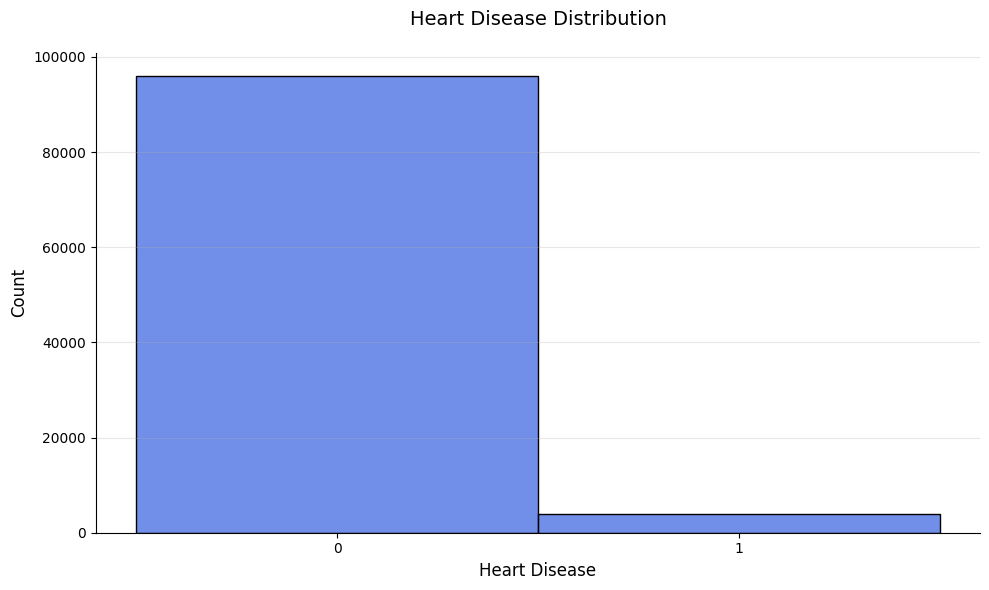

In [35]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, 
             x='heart_disease', 
             bins=[-0.5, 0.5, 1.5],  # Explicit bin edges centered at 0 and 1
             color='royalblue',
             edgecolor='black',
             )

plt.title('Heart Disease Distribution', fontsize=14, pad=20)
plt.xlabel('Heart Disease', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1]) 
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

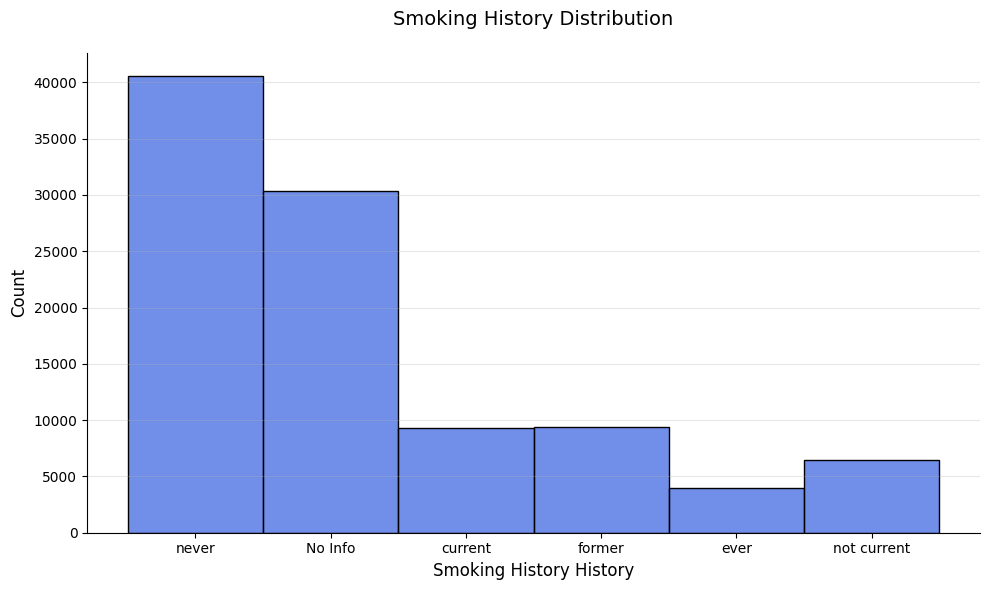

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='smoking_history', 
             bins=3,
             color='royalblue',
             edgecolor='black',
             )

plt.title('Smoking History Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('Smoking History History', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

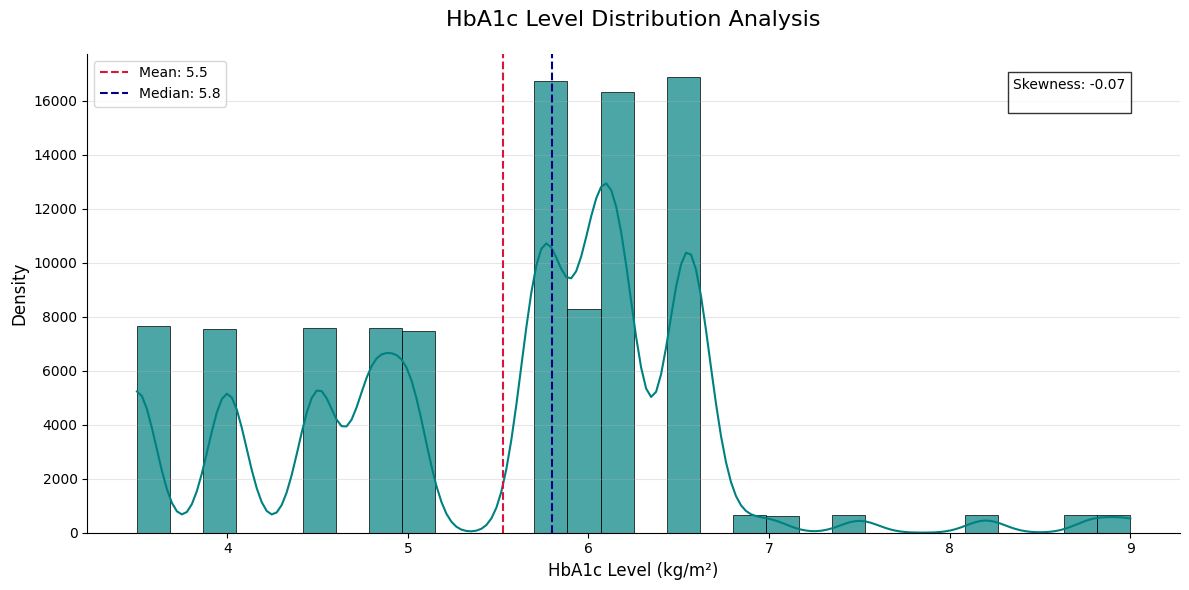

In [ ]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='HbA1c_level',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_HbA1c_level = df['HbA1c_level'].mean()
median_HbA1c_level = df['HbA1c_level'].median()
plt.axvline(mean_HbA1c_level, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_HbA1c_level:.1f}')
plt.axvline(median_HbA1c_level, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_HbA1c_level:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["HbA1c_level"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('HbA1c Level Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('HbA1c Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

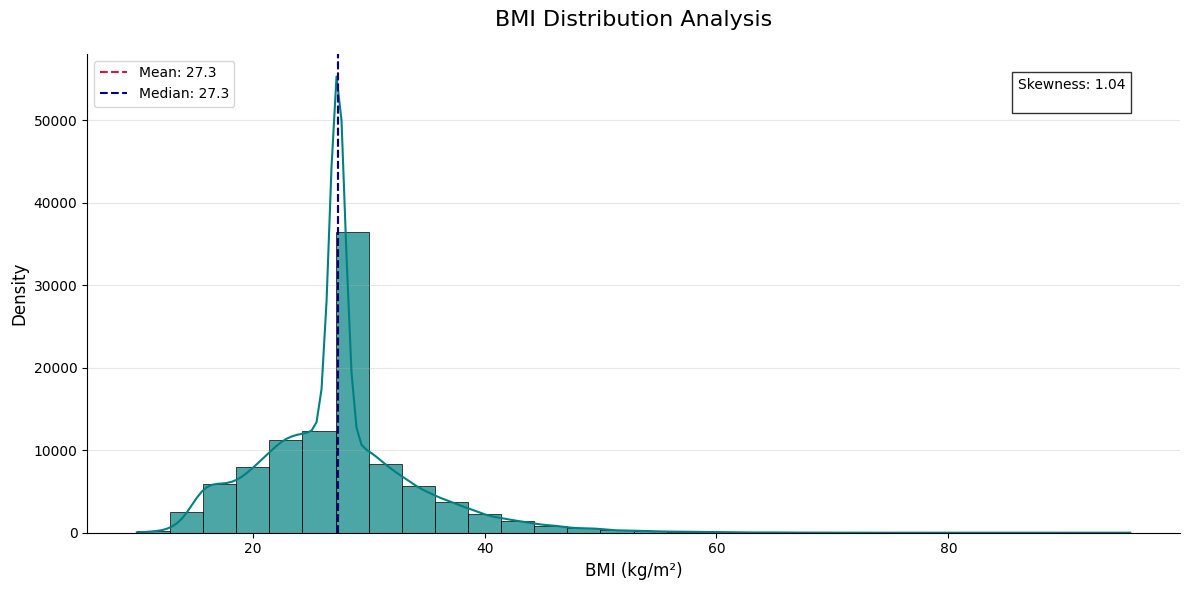

In [ ]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='bmi',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_bmi = df['bmi'].mean()
median_bmi = df['bmi'].median()
plt.axvline(mean_bmi, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_bmi:.1f}')
plt.axvline(median_bmi, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_bmi:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["bmi"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('BMI Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('BMI (kg/m²)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

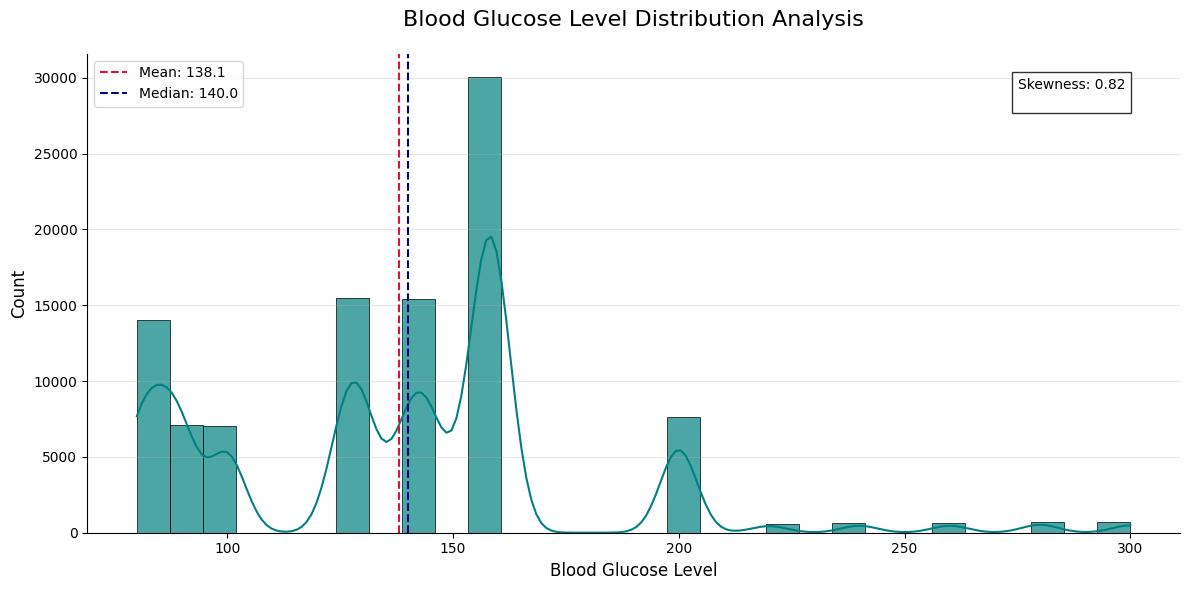

In [51]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='blood_glucose_level',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_blood_glucose_level = df['blood_glucose_level'].mean()
median_blood_glucose_level = df['blood_glucose_level'].median()
plt.axvline(mean_blood_glucose_level, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_blood_glucose_level:.1f}')
plt.axvline(median_blood_glucose_level, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_blood_glucose_level:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["blood_glucose_level"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('Blood Glucose Level Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('Blood Glucose Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

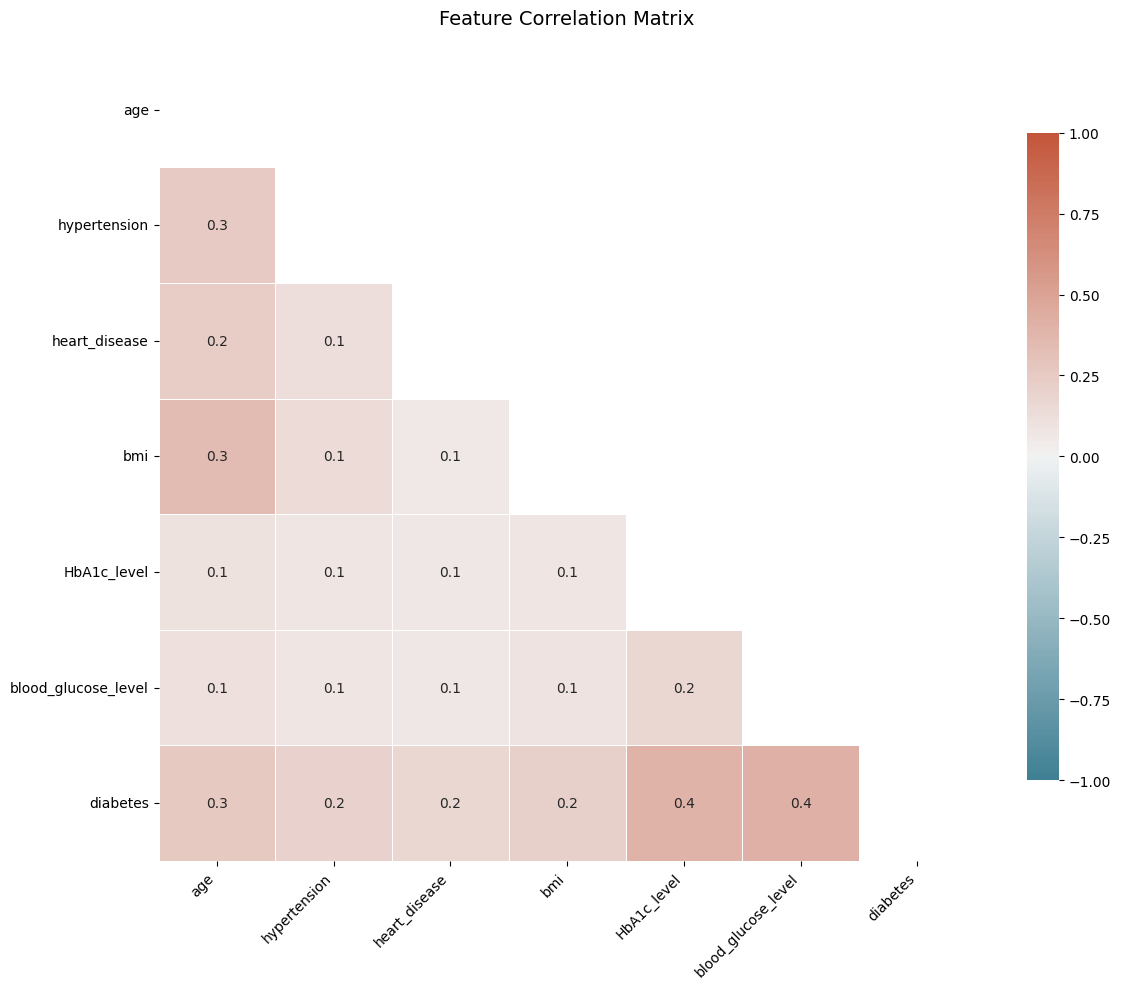

In [54]:
plt.figure(figsize=(12, 10))

# Calculate correlations
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Generate heatmap
ax = sns.heatmap(corr_matrix,
                 mask=mask,
                 cmap=cmap,
                 vmin=-1, vmax=1,
                 center=0,
                 annot=True,
                 fmt=".1f",
                 linewidths=0.5,
                 annot_kws={"size": 10},
                 cbar_kws={"shrink": 0.8})

# Improve readability
plt.title("Feature Correlation Matrix", fontsize=14, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Remove empty space
plt.tight_layout()
plt.show()